In [1]:
.libPaths(R.home('/opt/homebrew/Caskroom/miniforge/base/lib/R/library'))
Output = '/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1013. Microbiome Peanut Allergy/P1013.3. Analyses/P1013.3.3. Volcano Plots/Output'
cur_date = '011726'

library(readxl)
library(openxlsx)
library(writexl)
library(tidyverse)
library(ggrepel)
library(ggsci)

# reading in files
bl_saliva_adj = data.frame(Model = 'Saliva Outcome Comparison Pre Treatment', read_excel("Input/Saliva_Adj_Outcome_011526.xlsx")) %>%
    select(-Original_Name)
bl_stool_adj = data.frame(Model = 'Stool Outcome Comparison Pre Treatment', read_excel("Input/Stool_Adj_Outcome_011526.xlsx")) %>%
    select(-Original_Name)
post_saliva_adj = data.frame(Model = 'Saliva Outcome Comparison Post Treatment', read_excel("Input/Saliva_Adj_Post_Outcome_011526.xlsx")) %>%
    select(-Original_Name)
post_stool_adj = data.frame(Model = 'Stool Outcome Comparison Post Treatment', read_excel("Input/Stool_Adj_Post_Outcome_011526.xlsx")) %>%
    select(-Original_Name)
paired_saliva_adj = data.frame(Model = 'Saliva Paired Time Point Comparison', read_excel("Input/Saliva_Adj_Paired_011526.xlsx")) %>%
    select(-Original_Name)
paired_stool_adj = data.frame(Model = 'Stool Paired Time Point Comparison', read_excel("Input/Stool_Adj_Paired_011526.xlsx")) %>%
    select(-Original_Name)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
head(bl_saliva_adj)

,Model,Name,logFC,P.Value,P.Adj,Sensitivity.Analysis,diff_robust_OutcomeSU
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
1,Saliva Outcome Comparison Pre Treatment,Unassigned,0.29178065,0.462788934,0.85366752,TRUE,FALSE
2,Saliva Outcome Comparison Pre Treatment,Absconditabacteria_.SR1._.G.1. bacterium_HMT_874,0.76969087,0.054463067,0.24508380,TRUE,FALSE
3,Saliva Outcome Comparison Pre Treatment,Absconditabacteria_.SR1._.G.1. bacterium_HMT_875,12.06030124,1.000000000,1.00000000,TRUE,FALSE
4,Saliva Outcome Comparison Pre Treatment,Actinomyces,0.07289551,0.882512576,1.00000000,TRUE,FALSE
5,Saliva Outcome Comparison Pre Treatment,Actinomyces graevenitzii,-1.67165466,0.007295550,0.08535793,TRUE,FALSE
6,Saliva Outcome Comparison Pre Treatment,Schaalia lingnae,-0.90445448,0.004158115,0.06644521,TRUE,FALSE


Creating a volcano plot to visualize bacteria that were differentially abundant.

In [3]:
# combining dfs
baseline_adj_df = rbind(bl_saliva_adj, bl_stool_adj)
post_adj_df = rbind(post_saliva_adj, post_stool_adj)
paired_adj_df = rbind(paired_saliva_adj, paired_stool_adj)

In [4]:
get_significance = function(df){
    # adding a col to denote whether a Name1 had a significant p value, log FC, or both
    
    # add a column of NAs
    df$diffexpressed <- "No Significance"
    
    # if p adj is significant only
    df$diffexpressed[df$P.Adj < 0.1] <- "P Adjust Only"
    
    # if logFoldChange > log(1.5)? and p adj < 0.01, set as "significant" 
    df$diffexpressed[abs(df$logFC) > abs(log2(1.5)) & df$P.Adj < 0.1] <- "P Adjust and log Fold Change"
    
    # making into a factor
    df$diffexpressed = factor(df$diffexpressed, levels = c("No Significance", "P Adjust Only", 
                                                                           "P Adjust and log Fold Change"))

    return(df)
}

# calling fn
sig_baseline_adj_df = get_significance(baseline_adj_df)
sig_post_adj_df = get_significance(post_adj_df)
sig_paired_adj_df = get_significance(paired_adj_df)

In [5]:
# identifying genes commonly modulated across exposure groups to label them differently
sig_bl_saliva_bacteria = sig_baseline_adj_df %>%
    filter(Model == 'Saliva Outcome Comparison Pre Treatment', diffexpressed == "P Adjust and log Fold Change") %>%
    select(Name) %>% pull()

sig_bl_stool_bacteria = sig_baseline_adj_df %>%
    filter(Model == 'Stool Outcome Comparison Pre Treatment', diffexpressed == "P Adjust and log Fold Change") %>%
    select(Name) %>% pull()

sig_post_saliva_bacteria = sig_post_adj_df %>%
    filter(Model == 'Saliva Outcome Comparison Post Treatment', diffexpressed == "P Adjust and log Fold Change") %>%
    select(Name) %>% pull()

sig_post_stool_bacteria = sig_post_adj_df %>%
    filter(Model == 'Stool Outcome Comparison Post Treatment', diffexpressed == "P Adjust and log Fold Change") %>%
    select(Name) %>% pull()

sig_paired_saliva_bacteria = sig_paired_adj_df %>%
    filter(Model == 'Saliva Paired Time Point Comparison', diffexpressed == "P Adjust and log Fold Change") %>%
    select(Name) %>% pull()

sig_paired_stool_bacteria = sig_paired_adj_df %>%
    filter(Model == 'Stool Paired Time Point Comparison', diffexpressed == "P Adjust and log Fold Change") %>%
    select(Name) %>% pull()

`%notin%` <- Negate(`%in%`)

# finding bacteria that were significantly different pre and post in saliva
saliva_time_common_bacteria = intersect(sig_bl_saliva_bacteria, sig_post_saliva_bacteria)
saliva_time_uncommon_boolean = c(sig_bl_saliva_bacteria, sig_post_saliva_bacteria) %notin% saliva_time_common_bacteria
saliva_time_uncommon_bacteria = c(sig_bl_saliva_bacteria, sig_post_saliva_bacteria)[saliva_time_uncommon_boolean]

stool_time_common_bacteria = intersect(sig_bl_stool_bacteria, sig_post_stool_bacteria)
stool_time_uncommon_boolean = c(sig_bl_stool_bacteria, sig_post_stool_bacteria) %notin% stool_time_common_bacteria
stool_time_uncommon_bacteria = c(sig_bl_stool_bacteria, sig_post_stool_bacteria)[stool_time_uncommon_boolean]

saliva_paired_common_bacteria = intersect(sig_paired_saliva_bacteria, sig_bl_saliva_bacteria)
saliva_paired_uncommon_boolean = c(sig_paired_saliva_bacteria, sig_bl_saliva_bacteria) %notin% saliva_paired_common_bacteria
saliva_paired_uncommon_bacteria = c(sig_paired_saliva_bacteria, sig_bl_saliva_bacteria)[saliva_paired_common_bacteria]

stool_paired_common_bacteria = intersect(sig_paired_stool_bacteria, sig_bl_stool_bacteria)
stool_paired_uncommon_boolean = c(sig_paired_stool_bacteria, sig_bl_stool_bacteria) %notin% stool_paired_common_bacteria
stool_paired_uncommon_bacteria = c(sig_paired_stool_bacteria, sig_bl_stool_bacteria)[stool_paired_common_bacteria]

What bacteria are still significantly different between outcomes even after treatment?

In [6]:
saliva_time_common_bacteria
stool_time_common_bacteria

character(0)

[1] "Bacteroides caccae"         "Phocaeicola dorei"         
[3] "Alistipes putredinis"       "Mediterraneibacter torques"
[5] "Monoglobus pectinilyticus"  "Ruminiclostridium siraeum"

Just 6 bacteria in stool samples.

What bacteria were significantly different in this paired analysis that were significantly different across outcomes regardless of time point?

In [7]:
saliva_paired_common_bacteria
stool_paired_common_bacteria

[1] "Porphyromonas"     "Neisseria HMT_018"

[1] "Bacteroides caccae"

2 bacteria in saliva samples and 1 bacteria in stool samples.

In [8]:
# changing the dfs I want
saliva_time_point_df = rbind(sig_baseline_adj_df %>%
    filter(Model == 'Saliva Outcome Comparison Pre Treatment'),
                             sig_post_adj_df %>%
    filter(Model == 'Saliva Outcome Comparison Post Treatment')) %>%
    rename(`Sensitivity Analysis` = Sensitivity.Analysis)

stool_time_point_df = rbind(sig_baseline_adj_df %>%
    filter(Model == 'Stool Outcome Comparison Pre Treatment'),
                             sig_post_adj_df %>%
    filter(Model == 'Stool Outcome Comparison Post Treatment')) %>%
    rename(`Sensitivity Analysis` = Sensitivity.Analysis)

sig_paired_adj_df = sig_paired_adj_df %>%
    rename(`Sensitivity Analysis` = Sensitivity.Analysis)

saliva_time_point_df$Model = factor(saliva_time_point_df$Model, levels = c('Saliva Outcome Comparison Pre Treatment',
                                                                           'Saliva Outcome Comparison Post Treatment'))
stool_time_point_df$Model = factor(stool_time_point_df$Model, levels = c('Stool Outcome Comparison Pre Treatment',
                                                                           'Stool Outcome Comparison Post Treatment'))

# Volcano Plot

Warning message:
“Removed 14 rows containing missing values or values outside the scale range
(`geom_point()`).”


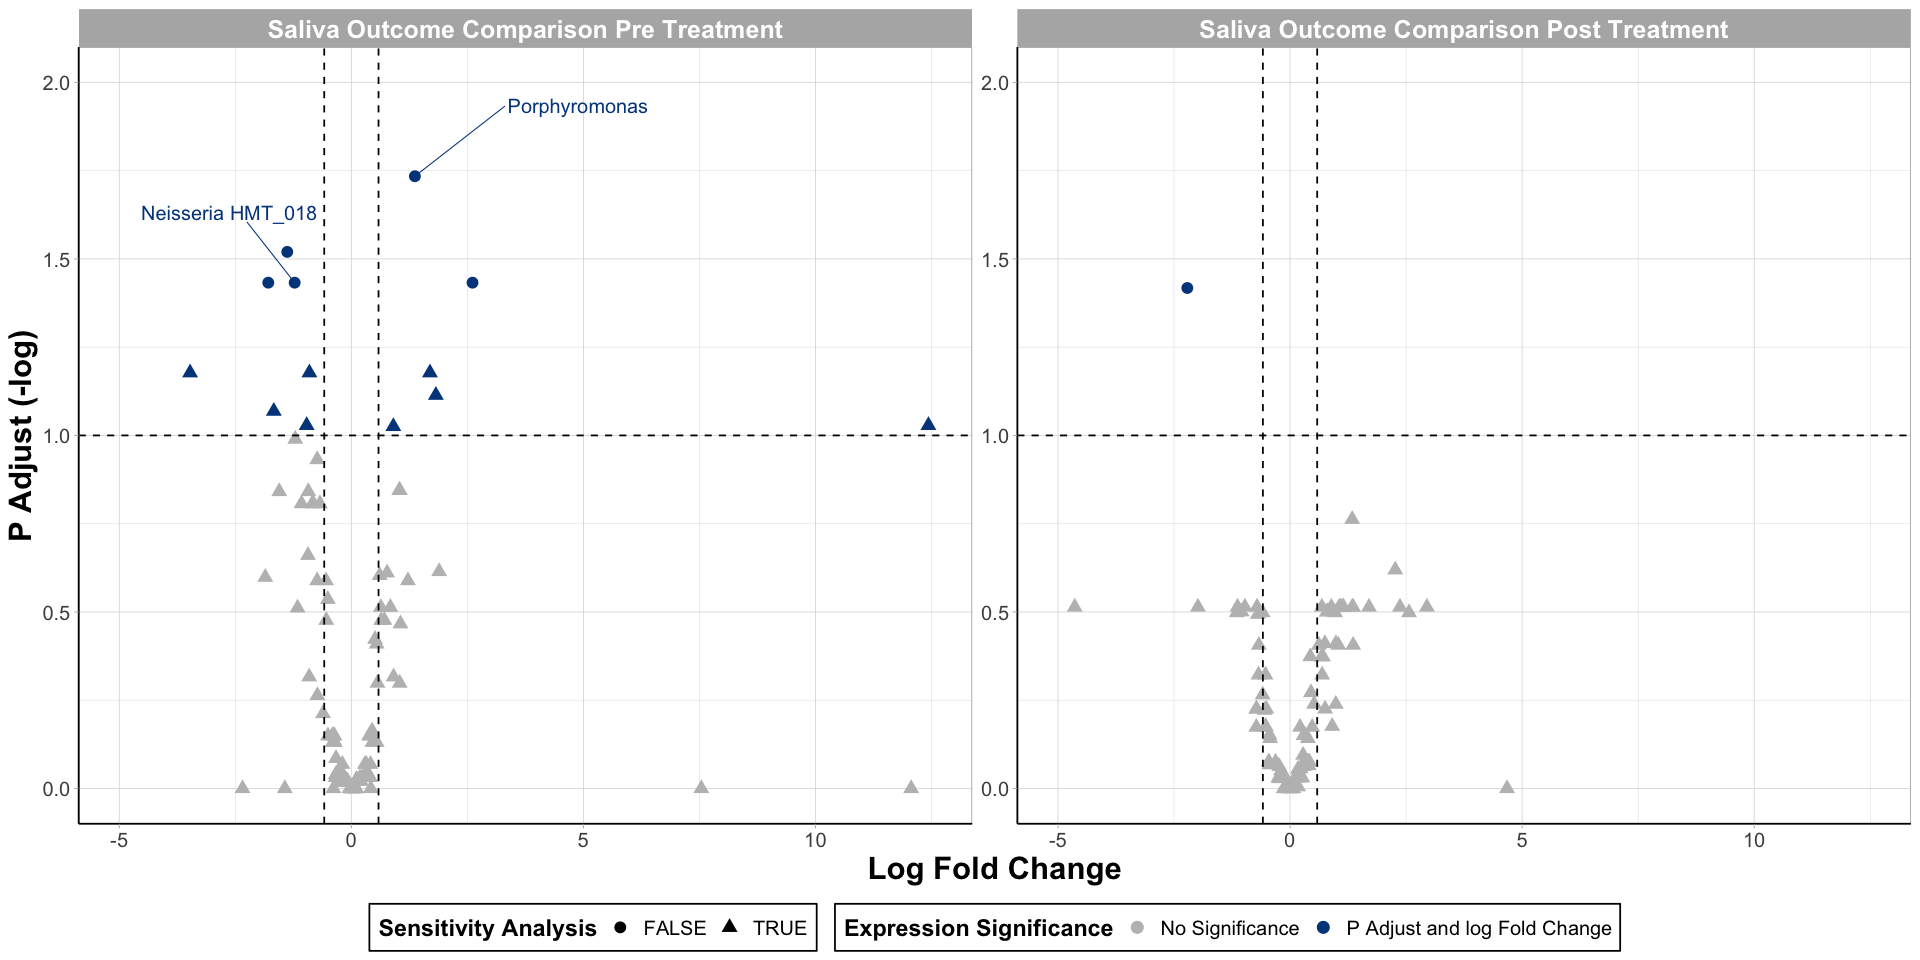

In [9]:
options(repr.plot.width=16, repr.plot.height=8) #changing size

lancet_palette = pal_lancet()(2)

ggplot() + 
  geom_point(data = saliva_time_point_df, aes(x = logFC, y = -log10(P.Adj), color = diffexpressed,
                             shape = `Sensitivity Analysis`), size = 3) + 

  # P Value line
  geom_hline(yintercept = -log10(0.1), linetype = "dashed") + 
  # FC Line
  geom_vline(xintercept = log2(1.5), linetype = "dashed") +
  geom_vline(xintercept = -log2(1.5), linetype = "dashed") +

  # changing x limits of what is visible in the plot
    xlim(-5, 12.5) + 
    ylim(0, 2) + 

 #  geom_text_repel(data = saliva_time_point_df %>%
 #                  filter(logFC > log(1.5) & logFC < 12, P.Adj < 0.1, Name %in% saliva_time_uncommon_bacteria), 
 #                  aes(x = logFC, y = -log10(P.Adj), label = Name, color = diffexpressed), xlim = c(3, NA), 
 #                  hjust = 'right', direction = 'y', nudge_y = 0.15, nudge_x = 2,
 #                  segment.size = 0.3, box.padding = 1, max.overlaps = Inf, size = 4.2, show.legend = FALSE) + 

 # geom_text_repel(data = saliva_time_point_df %>%
 #                  filter(logFC > 12, P.Adj < 0.1, Name %in% saliva_time_uncommon_bacteria), 
 #                  aes(x = logFC, y = -log10(P.Adj), label = Name, color = diffexpressed), xlim = c(3, 12), 
 #                  hjust = 'left', direction = 'y', nudge_y = 0.15, #nudge_x = 2,
 #                  segment.size = 0.3, box.padding = 1, max.overlaps = Inf, size = 4.2, show.legend = FALSE) + 

  geom_text_repel(data = saliva_time_point_df %>%
                  filter(logFC < -log2(1.5), P.Adj < 0.1, 
                         Name %in% c(saliva_paired_common_bacteria, stool_paired_common_bacteria)),
                  aes(x = logFC, y = -log10(P.Adj), label = Name, color = diffexpressed), xlim = c(-8, NA),
                  hjust = 'left', direction = 'y', nudge_y = 0.2, nudge_x = -3.3,
                 segment.size = 0.3, box.padding = 1, max.overlaps = Inf, size = 4.2, show.legend = FALSE) + 
  geom_text_repel(data = saliva_time_point_df %>%
                  filter(logFC > log2(1.5), P.Adj < 0.1, 
                         Name %in% c(saliva_paired_common_bacteria, stool_paired_common_bacteria)),
                  aes(x = logFC, y = -log10(P.Adj), label = Name, color = diffexpressed), #xlim = c(-8, NA),
                  hjust = 'left', direction = 'y', nudge_y = 0.2, nudge_x = 2,
                 segment.size = 0.3, box.padding = 1, max.overlaps = Inf, size = 4.2, show.legend = FALSE) + 

 # geom_text_repel(data = saliva_time_point_df %>%
 #                  filter(Model == 'Saliva Outcome Comparison Post Treatment', logFC < -log(1.5), P.Adj < 0.1, 
 #                         Name %in% saliva_time_uncommon_bacteria), 
 #                  aes(x = logFC, y = -log10(P.Adj), label = Name, color = diffexpressed), 
 #                  hjust = 'left', direction = 'y', nudge_y = 0.2, nudge_x = -5,
 #                 segment.size = 0.3, box.padding = 1, max.overlaps = Inf, size = 4.2, show.legend = FALSE) + 

  facet_wrap(~Model, scales = 'free') + 

  theme_light() + 
  theme(axis.line = element_line(colour = "black"), #making x and y axes black
        axis.text = element_text(size = 12), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 14), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", # changing legend position
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        strip.text.x = element_text(size = 15, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 15, face = "bold")) + #changes size of facet y axis 
  labs(x = "Log Fold Change", y = 'P Adjust (-log)') +

  scale_color_manual(name = "Expression Significance",
                      values = c("gray", lancet_palette[1]))

Warning message:
“Removed 40 rows containing missing values or values outside the scale range
(`geom_point()`).”


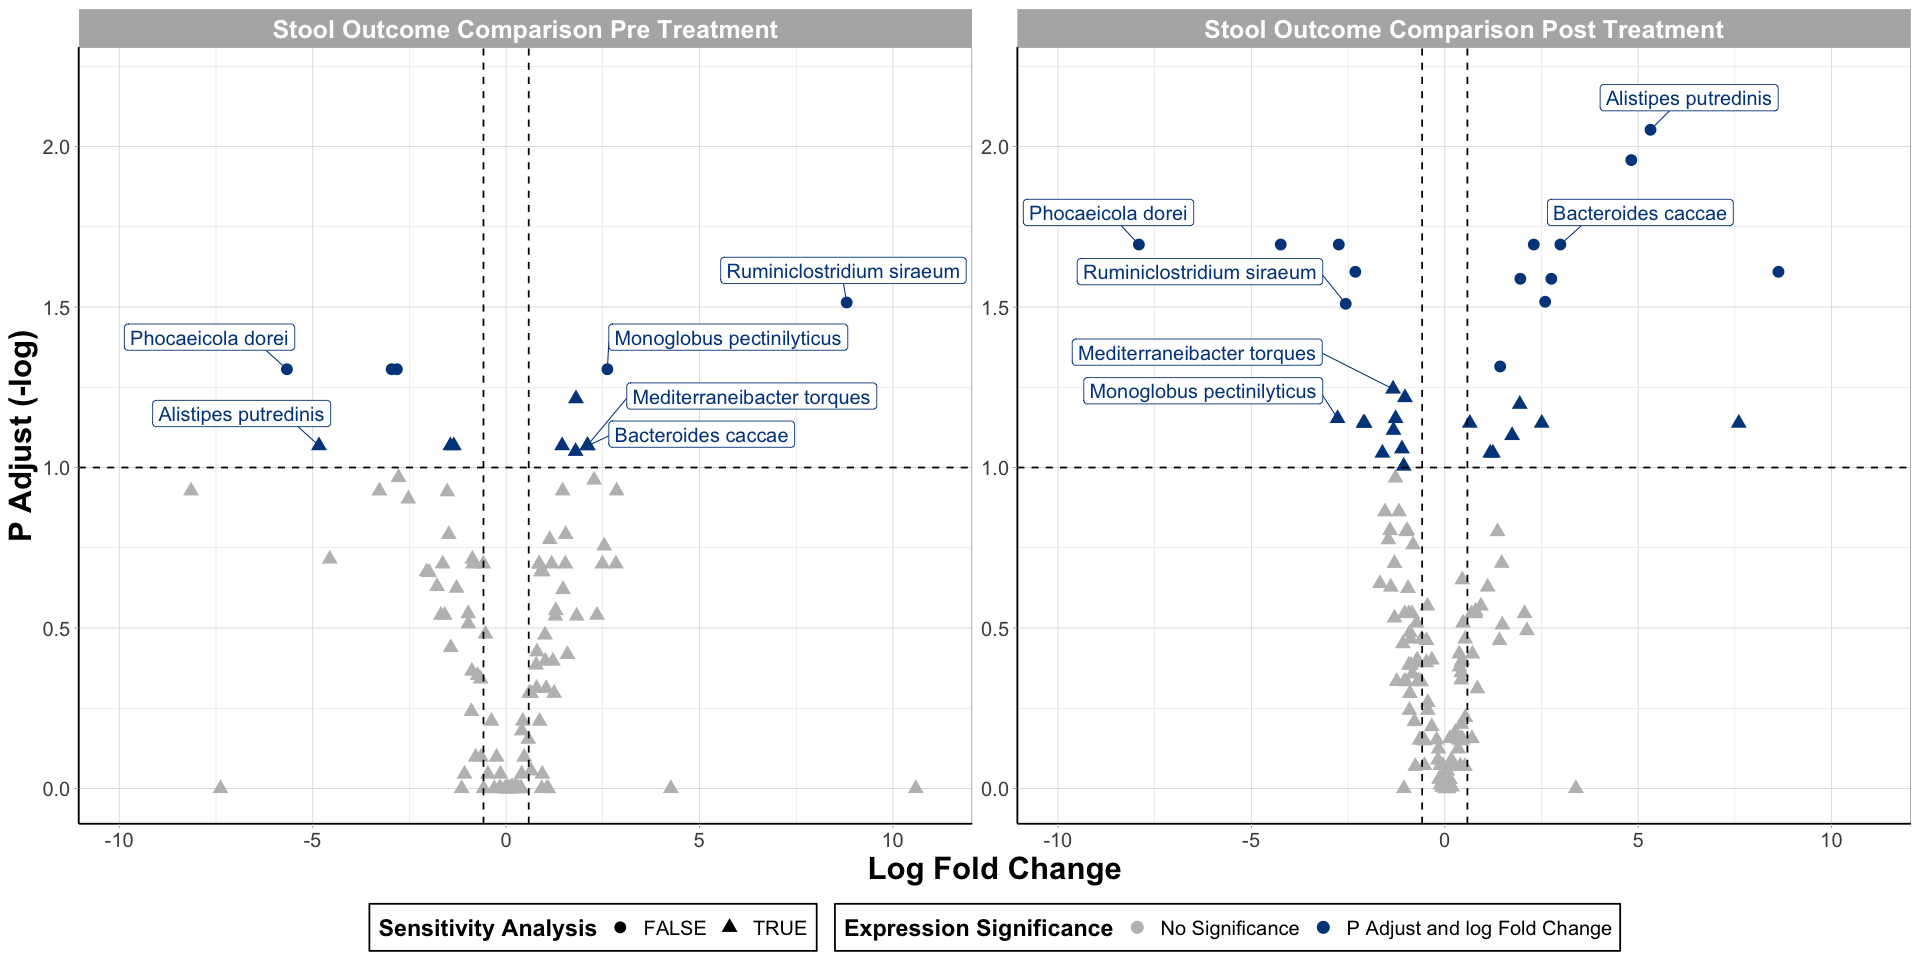

In [10]:
ggplot() + 
  geom_point(data = stool_time_point_df, aes(x = logFC, y = -log10(P.Adj), color = diffexpressed,
                             shape = `Sensitivity Analysis`), size = 3) + 

  # P Value line
  geom_hline(yintercept = -log10(0.1), linetype = "dashed") + 
  # FC Line
  geom_vline(xintercept = log2(1.5), linetype = "dashed") +
  geom_vline(xintercept = -log2(1.5), linetype = "dashed") +

  # changing x limits of what is visible in the plot
    xlim(-10, 11) + 
    ylim(0, 2.2) + 

 #labeling points with statistical significance and FC
  geom_label_repel(data = stool_time_point_df %>%
                  filter(logFC > log(1.5), Name %in% stool_time_common_bacteria), 
                  aes(x = logFC, y = -log10(P.Adj), label = Name, color = diffexpressed), nudge_x = 1, nudge_y = 0.1,
                  xlim = c(2.5, NA), segment.size = 0.3, max.overlaps = Inf, size = 4.2, show.legend = FALSE) + 

  geom_label_repel(data = stool_time_point_df %>%
                  filter(logFC < log(1.5), Name %in% stool_time_common_bacteria), 
                  aes(x = logFC, y = -log10(P.Adj), label = Name, color = diffexpressed), nudge_x = -2, nudge_y = 0.1,
                  xlim = c(NA, -3), segment.size = 0.3, max.overlaps = Inf, size = 4.2, show.legend = FALSE) + 

  #  geom_text_repel(data = stool_time_point_df %>%
  #                 filter(logFC > log(1.5), P.Adj < 0.1, Name %in% stool_time_uncommon_bacteria), 
  #                 aes(x = logFC, y = -log10(P.Adj), label = Name, color = diffexpressed), xlim = c(3, NA), 
  #                 hjust = 'right', direction = 'y', nudge_y = 0.1, nudge_x = 2,
  #                 segment.size = 0.3, box.padding = 1, max.overlaps = Inf, size = 4.2, show.legend = FALSE) + 

  # geom_text_repel(data = stool_time_point_df %>%
  #                 filter(logFC < -log(1.5), P.Adj < 0.1, Name %in% stool_time_uncommon_bacteria), 
  #                 aes(x = logFC, y = -log10(P.Adj), label = Name, color = diffexpressed), xlim = c(NA, -5),
  #                 hjust = 'left', direction = 'y', nudge_y = 0.15, nudge_x = -5,
  #                segment.size = 0.3, box.padding = 1, max.overlaps = Inf, size = 4.2, show.legend = FALSE) + 

  facet_wrap(~Model, scales = 'free') + 

  theme_light() + 
  theme(axis.line = element_line(colour = "black"), #making x and y axes black
        axis.text = element_text(size = 12), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 14), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", # changing legend position
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        strip.text.x = element_text(size = 15, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 15, face = "bold")) + #changes size of facet y axis 
  labs(x = "Log Fold Change", y = 'P Adjust (-log)') +

  scale_color_manual(name = "Expression Significance",
                      values = c("gray", lancet_palette[1]))

Warning message:
“Removed 6 rows containing missing values or values outside the scale range
(`geom_point()`).”


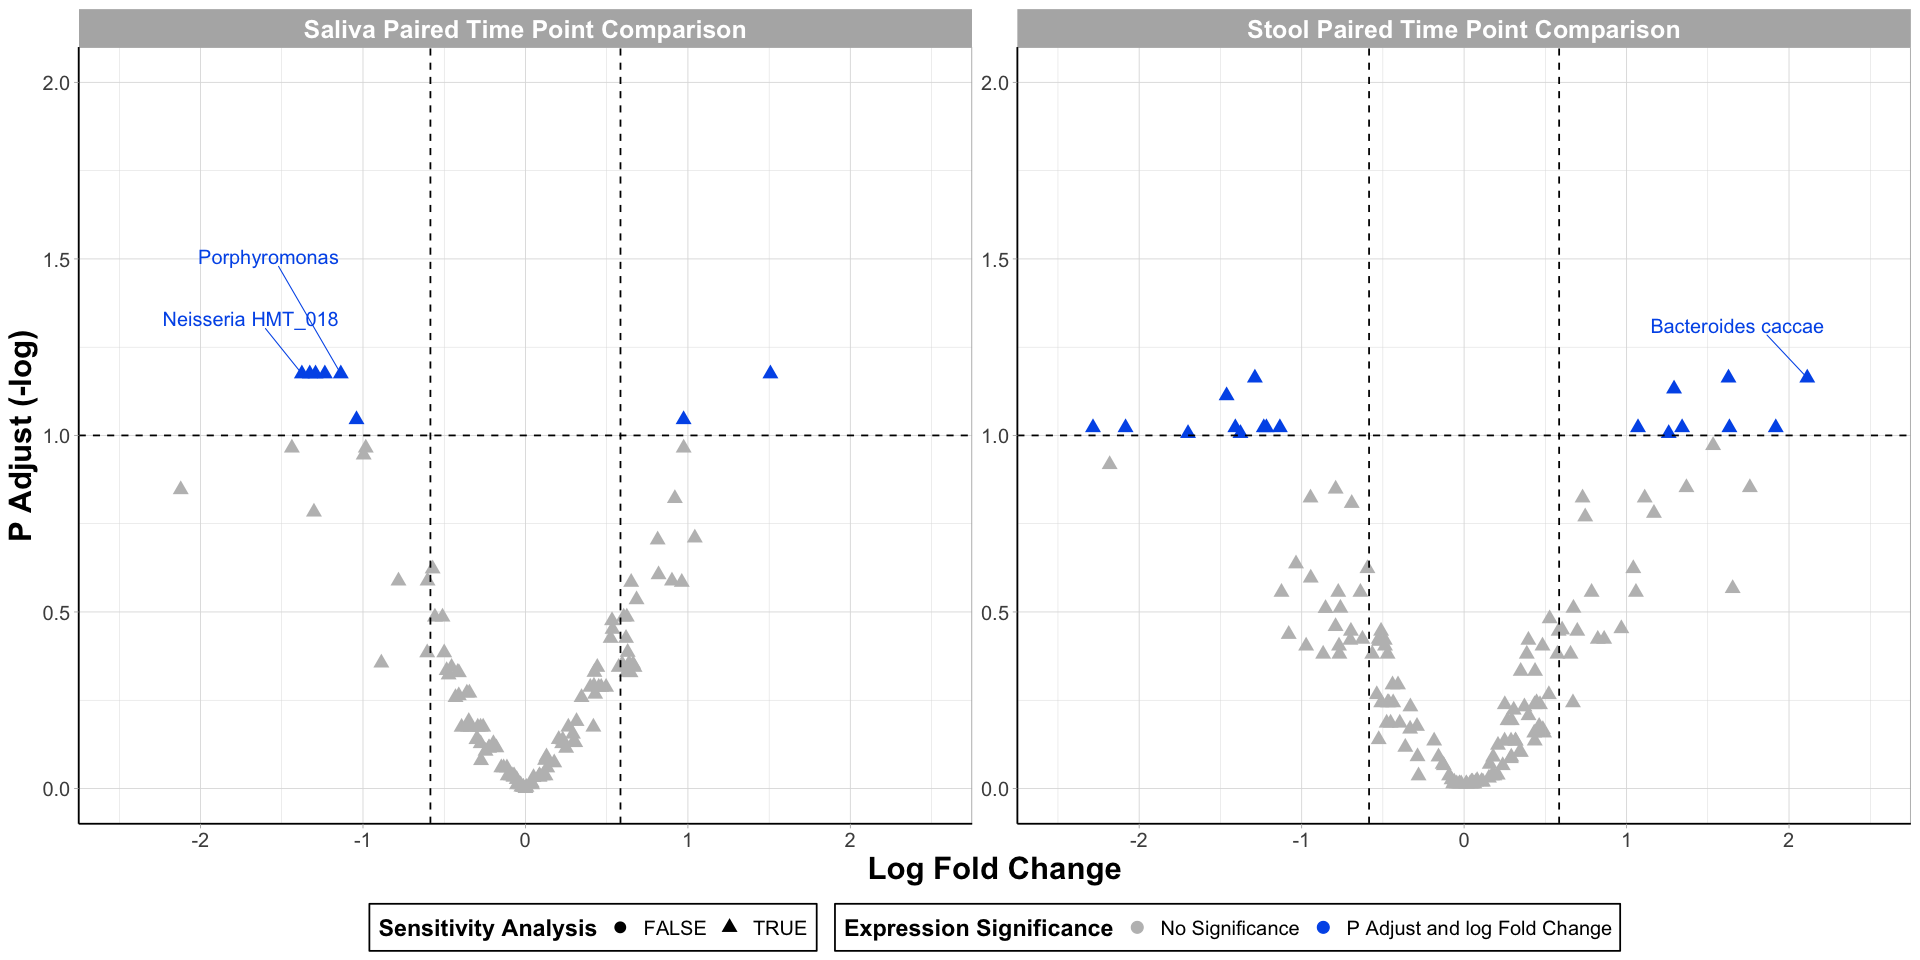

In [11]:
ggplot() + 
  geom_point(data = sig_paired_adj_df, aes(x = logFC, y = -log10(P.Adj), color = diffexpressed,
                             shape = `Sensitivity Analysis`), size = 3) + 

  # P Value line
  geom_hline(yintercept = -log10(0.1), linetype = "dashed") + 
  # FC Line
  geom_vline(xintercept = log2(1.5), linetype = "dashed") +
  geom_vline(xintercept = -log2(1.5), linetype = "dashed") +

  # changing x limits of what is visible in the plot
    xlim(-2.5, 2.5) + 
    ylim(0, 2) + 

 #labeling points with statistical significance and FC
   geom_text_repel(data = sig_paired_adj_df %>%
                  filter(logFC > log2(1.5), P.Adj < 0.1, 
                         Name %in% c(saliva_paired_common_bacteria, stool_paired_common_bacteria)), 
                  aes(x = logFC, y = -log10(P.Adj), label = Name, color = diffexpressed), xlim = c(1, NA), 
                  hjust = 'right', direction = 'y', nudge_y = 0.15, #nudge_x = 2,
                  segment.size = 0.3, box.padding = 1, max.overlaps = Inf, size = 4.2, show.legend = FALSE) + 

  geom_text_repel(data = sig_paired_adj_df %>%
                  filter(logFC < -log2(1.5), P.Adj < 0.1, 
                         Name %in% c(saliva_paired_common_bacteria, stool_paired_common_bacteria)), 
                  aes(x = logFC, y = -log10(P.Adj), label = Name, color = diffexpressed), xlim = c(NA, -1),
                   nudge_y = 0.2, nudge_x = -0.05,
                 segment.size = 0.3, box.padding = 1, max.overlaps = Inf, size = 4.2, show.legend = FALSE) + 

  facet_wrap(~Model, scales = 'free') + 

  theme_light() + 
  theme(axis.line = element_line(colour = "black"), #making x and y axes black
        axis.text = element_text(size = 12), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 14), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", # changing legend position
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        strip.text.x = element_text(size = 15, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 15, face = "bold")) + #changes size of facet y axis 
  labs(x = "Log Fold Change", y = 'P Adjust (-log)') +

  scale_color_manual(name = "Expression Significance",
                      values = c("gray", "#005BEA"))